# Image classification of simulated AT-TPC events

Welcome to this project in applied machine learning. In this project we will tackle a simple classification problem of two different classes. The classes are  simulated reaction types for the Ar(p, p') experiment conducted at MSU, in this task we'll focus on the classification task and simply treat the experiment as a black box. 

### This is a completed notebook with solution examples, for your implementation we suggest you implement your own solution in the `project.ipynb` notebook

This project has three tasks with a recommendation for the time to spend on each task: 

- Preparation, Data exploration and standardization: 0.5hr
- Model construction: 1hr
- Hyperparameter tuning and performance validation: 1hr

There is a notebook `project_solution.ipynb` included with suggestions to solutions for each task included, for reference or to easily move on to a part of the project more appealing to your interests. 

## Preparation: 

This project uses python and the machine learning library `keras`. As well as some functionality from `numpy` and `scikit-learn`. We recommend a `Python` verson of `>3.4`. These libraries should be installed to your specific system by using the command `pip3 install --user LIBRARY_NAME`

## Task 1: Data exploration and standardization 

In machine learning, as in many other fields, the task of preparing data for analysis is as vital as it can be troublesome and tedious. In data-analysis the researcher can expect to spend the majority of their time merely processing data to prepare for analysis. In this projcet we will focus more on the entire pipeline of analysis, and so the data at hand has already been shaped to an image format suitable for our analysis. 

## Task 1a: Loading the data

The data is stored in the `.npy` format using vecotrized code to speed up the read process. The files pointed to in this task are downsampled images with dimensions $64 x 64$ (if the images are to big for your laptop to handle, the script included in `../scripts/downsample_images.py` can further reduce the dimension). 

In [6]:
import numpy as np # we'll be using this shorthand for the NumPy library throughout

dataset = np.load("../data/images/project_data.npy")
n_samples = dataset.shape[0]

print("Data shape: ", dataset.shape)

Data shape:  (8000, 64, 64, 1)


## Task 1b: Inspecting the data

The data is stored as xy projections of the real events, who take place in a 3d volume. This allows a simple exploratiuon of the data as images. In this task you should plot a few different events in a grid using `matplotlib.pyplot` 

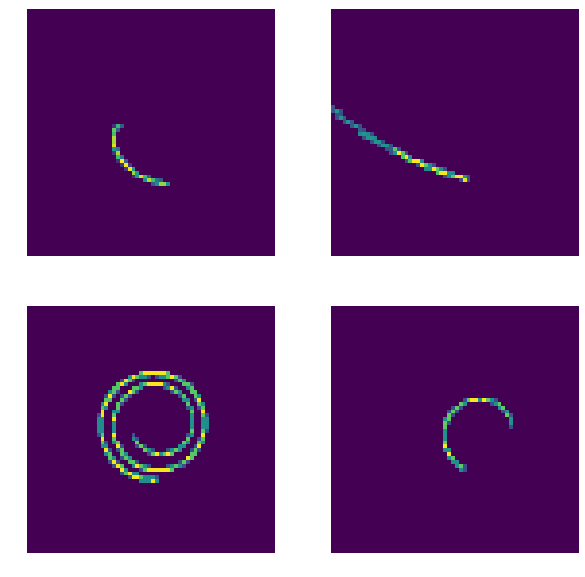

In [11]:
import matplotlib.pyplot as plt

rows = 2
cols = 2
n_plots = rows*cols
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10 ))


for row in axs: 
    for ax in row:
        """
        one of pythons most wonderful attributes is that if an object is iterable it can be
        directly iterated over, like above. 
        ax is an axis object from the 2d array of axis objects
        """

        which = np.random.randint(0, n_samples)
        ax.imshow(dataset[which].reshape(64, 64))
        ax.axis("off")
 

## Task 1c: Standardizing the data
An important part of the preprocessing of data is the standardization of the input. The intuition here is simply that the model should expect similar values in the input to mean the same. 

You should implement a standardization of the input. Perhaps the most common standardization is the centering of the mean of the distribution, and scaling by the standard deviation: 

$X_s = \frac{X - \mu}{\sigma}$

Note that for our data we only want to standardize the signal part of our image, we know the rest is zero and we don't want the standardization to be unduly effected. This also means we don't necessarily want a zero mean for our signal distribution. So for this example we stick with the scaling:

$X_s = \frac{X}{\sigma}$

Another important fact is that at already at this point is it recommended to separate the data in train and test sets. The partion of the data to test on should be roughly 10-20%. And to remember to compute the standardization variables only from the training set.

In [37]:
from sklearn.model_selection import train_test_split

targets = np.load("../data/targets/project_targets.npy")
train_X, test_X, train_y, test_y = train_test_split(dataset, targets, test_size=0.15)

nonzero_indices = np.nonzero(train_X)
nonzero_elements = train_X[nonzero_indices]

print("Train Mean: ", nonzero_elements.mean())
print("Train Std.: ", nonzero_elements.std())
print("-------------")
print("Test Mean: ", test_X[np.nonzero(test_X)].mean())
print("Test Std.: ", test_X[np.nonzero(test_X)].std())
print("############")

nonzero_scaled = nonzero_elements/nonzero_elements.std()
train_X[nonzero_indices] = nonzero_scaled
test_X[np.nonzero(test_X)] /= nonzero_elements.std()

print("Train Mean: ", nonzero_scaled.mean())
print("Train Std.: ", nonzero_scaled.std())
print("-------------")
print("Test Mean: ", test_X[np.nonzero(test_X)].mean())
print("Test Std.: ", test_X[np.nonzero(test_X)].std())

Train Mean:  1.1661787282024227
Train Std.:  4.498873508156905
-------------
Test Mean:  1.105126519078845
Test Std.:  4.20416144539155
############
Train Mean:  0.259215718354389
Train Std.:  0.9999999999999997
-------------
Test Mean:  0.2456451636337721
Test Std.:  0.934492031787288


#### We also want to plot up the data again to confirm that our scaling is sensible, you should reuse your code from above for this. 

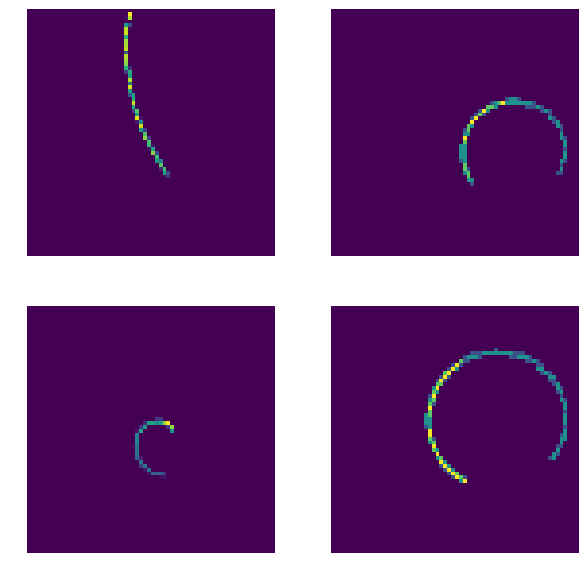

In [32]:
import matplotlib.pyplot as plt

rows = 2
cols = 2
n_plots = rows*cols
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10 ))


for row in axs: 
    for ax in row:
        """
        one of pythons most wonderful attributes is that if an object is iterable it can be
        directly iterated over, like above. 
        ax is an axis object from the 2d array of axis objects
        """

        which = np.random.randint(0, train_X.shape[0])
        ax.imshow(train_X[which].reshape(64, 64))
        ax.axis("off")

## 1d: Encoding the targets: 

For classification one ordinarily encodes the target as a n-element zero vector with one element valued at 1 indicating the target class. This is simply called one-hot encoding.

You should inspect the values of the target vectors and use the imported `OneHotEncoder` to convert the targets. 

In [34]:
from sklearn.preprocessing import OneHotEncoder



## 2a: Creating a model

In this task we will create a CNN with fully connected bottom-layers for classification. You should base your code on Morten's code for a model. We suggest yo do one of the following for this task: 

1. Implement a class or function `cnn` that returns a compiled Keras model with an arbitrary number of convolutional and fully connected layers with optional configuration of regularization terms or layers.
2. Implement a simple hard-coded function `cnn` that returns a Keras model object. The architecture should be specified in the function. 

Both implementations should include multiple convolutional layers and ending with a couple fully connected layers. The output of the network should be a softmax or log-softmax layer of logits.  

You should experiment with where in the network you place the non-linearities and whether to use striding or pooling to reduce the input. 

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten

def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    """
    Modified from MH Jensen's course on machine learning in physics: 
    https://github.com/CompPhysics/MachineLearningMSU/blob/master/doc/pub/CNN/ipynb/CNN.ipynb
    """
    model = Sequential()
    model.add(Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu', kernel_regularizer=l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(n_neurons_connected, activation='relu', kernel_regularizer=l2(lmbd)))
    model.add(Dense(n_categories, activation='softmax', kernel_regularizer=l2(lmbd)))
    
    sgd = SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model